In [1]:
import pandas as pd
base_dir = f'/mnt/lustre/koa/class/atmo449_class/students/team_1_flood_risk/'
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from wrf_diffusion.nimbuspp.parallel import parallelize

In [2]:
df_metadata = pd.read_csv(f'{base_dir}/raw_data/station_metadata.csv')

In [4]:
df_metadata['station_id'].head(10)

0    16104200
1    16103000
2    16097500
3    16094150
4    16114800
5    16108000
6    16010000
7    16016000
8    16019000
9    16060950
Name: station_id, dtype: int64

In [ ]:
station_id = df_metadata.iloc[1]['station_id']
station_id = 16016000

def resample_filter(station_id):
    df_gauge = pd.read_csv(
        f"{base_dir}/raw_data/gauge_observations/{station_id}.csv", dtype={'measurement': str}
        ).query('DQF == "A"').drop(columns=['DQF', 'station_id'])
    df_gauge['hst_timestamp'] = pd.to_datetime(df_gauge['hst_timestamp'])
    df_gauge['measurement'] = df_gauge['measurement'].astype(float)

    # drop any measurements taken at timestamps not divisible by 5 mins.
    df_gauge['is_divisible_by_5mins'] = (df_gauge['hst_timestamp'] - df_gauge['hst_timestamp'].dt.floor(freq='5min')) == pd.Timedelta(seconds=0)
    if ~df_gauge['is_divisible_by_5mins'].sum() > 10:
        raise ValueError()
    df_gauge_5min_resolution = df_gauge[df_gauge['is_divisible_by_5mins']].drop(columns=['is_divisible_by_5mins'])

    df_gauge_5min_resolution['interval'] = df_gauge_5min_resolution['hst_timestamp'] - df_gauge_5min_resolution['hst_timestamp'].shift(1)
    assert df_gauge_5min_resolution['interval'].min() >= pd.Timedelta(minutes=5)
    df_resampled = df_gauge_5min_resolution.resample('15min', on='hst_timestamp').mean().dropna().drop(columns=['interval'])
    
    # Calculate the data coverage and save only if enough coverage
    start, end = pd.Timestamp('2008-01-01', tz="HST"), pd.Timestamp('2024-12-31', tz="HST")
    df_resampled_filtered = df_resampled[(df_resampled.index >= start) & (df_resampled.index <= end)]

    recovery_rate = df_resampled_filtered.shape[0] / pd.date_range(start, end, freq='15min').shape[0]
    if recovery_rate > 0.85:
        print(f"Saving data for {station_id}")
        df_resampled_filtered.to_csv(f"{base_dir}/preprocessed_data/selected_flowgauge_15mins/{station_id}.csv")
    else:
        print(f"Coverage is low: {recovery_rate:.3f}. Skipping {station_id}")

In [6]:
resample_filter(station_id)

AssertionError: 

In [9]:
df_gauge = pd.read_csv(
    f"{base_dir}/raw_data/gauge_observations/{station_id}.csv", dtype={'measurement': str}
    ).query('DQF == "A"').drop(columns=['DQF', 'station_id'])
df_gauge['hst_timestamp'] = pd.to_datetime(df_gauge['hst_timestamp'])
df_gauge['measurement'] = df_gauge['measurement'].astype(float)

# # drop any measurements taken at timestamps not divisible by 5 mins.
# df_gauge['is_divisible_by_5mins'] = (df_gauge['hst_timestamp'] - df_gauge['hst_timestamp'].dt.floor(freq='5min')) == pd.Timedelta(seconds=0)
# if ~df_gauge['is_divisible_by_5mins'].sum() > 10:
#     raise ValueError()
# df_gauge_5min_resolution = df_gauge[df_gauge['is_divisible_by_5mins']].drop(columns=['is_divisible_by_5mins'])

# df_gauge_5min_resolution['interval'] = df_gauge_5min_resolution['hst_timestamp'] - df_gauge_5min_resolution['hst_timestamp'].shift(1)

In [10]:
df_gauge

,hst_timestamp,measurement


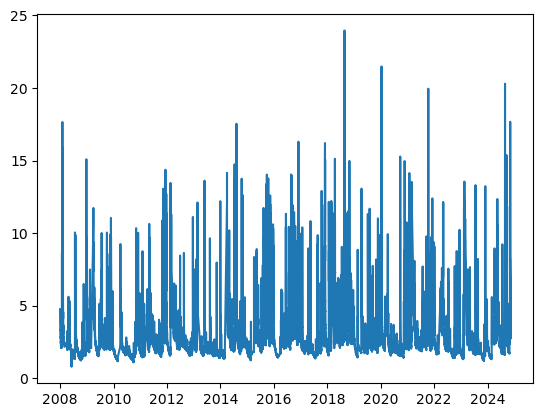

In [10]:
plt.plot(df_resampled_filtered['measurement'])

In [227]:
station_id

16103000

In [230]:
116865 / (24*(2022-2007)*465)

0.6981182795698925

In [171]:
def accept(g):
    if g.count() >= 2:
        return g.mean()
    else:
        return np.nan
    
df_gauge_5min_resolution.resample('15min').mean().tail()

,measurement,interval
hst_timestamp,,
2022-08-10 10:30:00-10:00,-0.420000,0 days 00:05:00
2022-08-10 10:45:00-10:00,-0.420000,0 days 00:05:00
2022-08-10 11:00:00-10:00,-0.416667,0 days 00:05:00
2022-08-10 11:15:00-10:00,-0.420000,0 days 00:05:00
2022-08-10 11:30:00-10:00,-0.430000,0 days 00:05:00


In [172]:
df_gauge_5min_resolution.resample('15min').asfreq().tail()

,measurement,interval
hst_timestamp,,
2022-08-10 10:30:00-10:00,-0.42,0 days 00:05:00
2022-08-10 10:45:00-10:00,-0.42,0 days 00:05:00
2022-08-10 11:00:00-10:00,-0.41,0 days 00:05:00
2022-08-10 11:15:00-10:00,-0.41,0 days 00:05:00
2022-08-10 11:30:00-10:00,-0.43,0 days 00:05:00


In [173]:
df_gauge_5min_resolution.tail()

,measurement,interval
hst_timestamp,,
2022-08-10 11:10:00-10:00,-0.42,0 days 00:05:00
2022-08-10 11:15:00-10:00,-0.41,0 days 00:05:00
2022-08-10 11:20:00-10:00,-0.42,0 days 00:05:00
2022-08-10 11:25:00-10:00,-0.43,0 days 00:05:00
2022-08-10 11:30:00-10:00,-0.43,0 days 00:05:00


In [144]:
# freq = pd.infer_freq(df_gauge_5min_resolution.index)

In [140]:
df_gauge_5min_resolution#.resample('5min').asfreq()

,measurement,interval
hst_timestamp,,
2007-10-01 00:00:00-10:00,2.83,NaT
2007-10-01 00:15:00-10:00,2.82,0 days 00:15:00
2007-10-01 00:30:00-10:00,2.81,0 days 00:15:00
2007-10-01 00:45:00-10:00,2.79,0 days 00:15:00
2007-10-01 01:00:00-10:00,2.77,0 days 00:15:00
...,...,...
2022-08-10 11:10:00-10:00,-0.42,0 days 00:05:00
2022-08-10 11:15:00-10:00,-0.41,0 days 00:05:00
2022-08-10 11:20:00-10:00,-0.42,0 days 00:05:00


In [134]:
df_gauge_5min_resolution.groupby(df_gauge_5min_resolution['hst_timestamp'].dt.floor('15min')).apply(lambda g: len(g))

hst_timestamp
2007-10-01 00:00:00-10:00    1
2007-10-01 00:15:00-10:00    1
2007-10-01 00:30:00-10:00    1
2007-10-01 00:45:00-10:00    1
2007-10-01 01:00:00-10:00    1
                            ..
2022-08-10 10:30:00-10:00    3
2022-08-10 10:45:00-10:00    3
2022-08-10 11:00:00-10:00    3
2022-08-10 11:15:00-10:00    3
2022-08-10 11:30:00-10:00    1
Length: 467022, dtype: int64

In [ ]:
# # drop any measurements taken at timestamps not divisible by 5 mins.
# df_gauge['is_divisible_by_5mins'] = (df_gauge.index - df_gauge.index.dt.floor(freq='5min')) > pd.Timedelta(seconds=1)
# if df_gauge['is_divisible_by_5mins'].sum() > 10:
#     raise ValueError()
# df_gauge = df_gauge[~df_gauge['is_divisible_by_5mins']].copy()

# df_gauge['interval'] = df_gauge['hst_timestamp'] - df_gauge['hst_timestamp'].shift(1)

In [80]:
df_gauge['interval'].unique().min()

Timedelta('0 days 00:05:00')

In [81]:
df_gauge

,hst_timestamp,measurement,is_divisible_by_5mins,interval
0,2007-10-01 00:00:00-10:00,2.83,False,NaT
1,2007-10-01 00:15:00-10:00,2.82,False,0 days 00:15:00
2,2007-10-01 00:30:00-10:00,2.81,False,0 days 00:15:00
3,2007-10-01 00:45:00-10:00,2.79,False,0 days 00:15:00
4,2007-10-01 01:00:00-10:00,2.77,False,0 days 00:15:00
...,...,...,...,...
798057,2022-08-10 11:10:00-10:00,-0.42,False,0 days 00:05:00
798058,2022-08-10 11:15:00-10:00,-0.41,False,0 days 00:05:00
798059,2022-08-10 11:20:00-10:00,-0.42,False,0 days 00:05:00
798060,2022-08-10 11:25:00-10:00,-0.43,False,0 days 00:05:00


In [29]:
df_gauge.iloc[364380:364390]

,hst_timestamp,measurement,interval


In [16]:
df_gauge['interval'].unique().min()

Timedelta('0 days 00:01:00')

In [8]:
df_gauge

,hst_timestamp,measurement,interval
0,2007-10-01 00:00:00-10:00,2.83,None
1,2007-10-01 00:15:00-10:00,2.82,2007-10-01 00:00:00-10:00
2,2007-10-01 00:30:00-10:00,2.81,2007-10-01 00:15:00-10:00
3,2007-10-01 00:45:00-10:00,2.79,2007-10-01 00:30:00-10:00
4,2007-10-01 01:00:00-10:00,2.77,2007-10-01 00:45:00-10:00
...,...,...,...
798057,2022-08-10 11:10:00-10:00,-0.42,2022-08-10 11:05:00-10:00
798058,2022-08-10 11:15:00-10:00,-0.41,2022-08-10 11:10:00-10:00
798059,2022-08-10 11:20:00-10:00,-0.42,2022-08-10 11:15:00-10:00
798060,2022-08-10 11:25:00-10:00,-0.43,2022-08-10 11:20:00-10:00


In [ ]:
# def get_data_availability(args):
#     station_id = args['station_id']
#     data_availability = {'station_id': station_id, 'start_date': None, 'end_date': None, 'N_data': 0, 'availability_%': 0}
#     df_gauge = pd.read_csv(f"{base_dir}/raw_data/gauge_observations/{station_id}.csv", dtype={'measurement': str}).query('DQF == "A"').drop(columns=['DQF', 'station_id'])
#     if len(df_gauge) == 0:
#         return data_availability

#     df_gauge['hst_timestamp'] = pd.to_datetime(df_gauge['hst_timestamp'])
#     df_gauge['measurement'] = np.array(df_gauge['measurement'])
#     df_gauge.set_index('hst_timestamp', inplace=True)

#     total_len = pd.date_range(df_gauge.index.min(), df_gauge.index.max(), freq='15min').shape[0]
#     availability = df_gauge.shape[0] / total_len
#     data_availability['availability_%'] = availability * 100
#     data_availability['start_date'] = df_gauge.index.min().strftime('%Y/%m/%d')
#     data_availability['end_date'] = df_gauge.index.max().strftime('%Y/%m/%d')
#     data_availability['N_data'] = df_gauge.shape[0]
#     return data_availability

In [3]:
df_metadata = pd.read_csv(f'{base_dir}/raw_data/station_metadata.csv')
ret = parallelize(func=get_data_availability, args=[dict(station_id=sid) for sid in df_metadata['station_id']])

  0%|                                                                                                                                                                                      | 0/102 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [01:31<00:00,  1.11it/s]


In [11]:
station_id=16103000
df_gauge = pd.read_csv(f"{base_dir}/raw_data/gauge_observations/{station_id}.csv", dtype={'measurement': str}).query('DQF == "A"').drop(columns=['DQF', 'station_id'])

df_gauge['hst_timestamp'] = pd.to_datetime(df_gauge['hst_timestamp'])
df_gauge['measurement'] = np.array(df_gauge['measurement'])
df_gauge.set_index('hst_timestamp', inplace=True)

In [ ]:
total_len = pd.date_range(df_gauge.index.min(), df_gauge.index.max(), freq='15min').shape[0]
df_gauge.shape[0], total_len

(796931, 521039)

In [31]:
pd.date_range(df_gauge.index.min(), df_gauge.index.max(), freq='15min')

DatetimeIndex(['2007-10-01 00:00:00-10:00', '2007-10-01 00:15:00-10:00',
               '2007-10-01 00:30:00-10:00', '2007-10-01 00:45:00-10:00',
               '2007-10-01 01:00:00-10:00', '2007-10-01 01:15:00-10:00',
               '2007-10-01 01:30:00-10:00', '2007-10-01 01:45:00-10:00',
               '2007-10-01 02:00:00-10:00', '2007-10-01 02:15:00-10:00',
               ...
               '2022-08-10 09:15:00-10:00', '2022-08-10 09:30:00-10:00',
               '2022-08-10 09:45:00-10:00', '2022-08-10 10:00:00-10:00',
               '2022-08-10 10:15:00-10:00', '2022-08-10 10:30:00-10:00',
               '2022-08-10 10:45:00-10:00', '2022-08-10 11:00:00-10:00',
               '2022-08-10 11:15:00-10:00', '2022-08-10 11:30:00-10:00'],
              dtype='datetime64[ns, UTC-10:00]', length=521039, freq='15min')

In [30]:
df_gauge.index

DatetimeIndex(['2007-10-01 00:00:00-10:00', '2007-10-01 00:15:00-10:00',
               '2007-10-01 00:30:00-10:00', '2007-10-01 00:45:00-10:00',
               '2007-10-01 01:00:00-10:00', '2007-10-01 01:15:00-10:00',
               '2007-10-01 01:30:00-10:00', '2007-10-01 01:45:00-10:00',
               '2007-10-01 02:00:00-10:00', '2007-10-01 02:15:00-10:00',
               ...
               '2022-08-10 10:45:00-10:00', '2022-08-10 10:50:00-10:00',
               '2022-08-10 10:55:00-10:00', '2022-08-10 11:00:00-10:00',
               '2022-08-10 11:05:00-10:00', '2022-08-10 11:10:00-10:00',
               '2022-08-10 11:15:00-10:00', '2022-08-10 11:20:00-10:00',
               '2022-08-10 11:25:00-10:00', '2022-08-10 11:30:00-10:00'],
              dtype='datetime64[ns, UTC-10:00]', name='hst_timestamp', length=796931, freq=None)

In [25]:
# plt.plot(df_gauge.index)#.is_unique
# plt.plot(pd.date_range(df_gauge.index.min(), df_gauge.index.max(), freq='15min'))

In [26]:
# plt.plot(pd.date_range(df_gauge.index.min(), df_gauge.index.max(), freq='15min'))

In [9]:
get_data_availability(dict(station_id=16103000))

{'station_id': 16103000,
 'start_date': '2007/10/01',
 'end_date': '2022/08/10',
 'N_data': 796931,
 'availability_%': 152.9503549638319}

In [8]:
n_sta = 0
for meta in ret:
    if meta['availability_%'] < 80:
        continue
    else:
        print(meta)
        n_sta += 1
print(n_sta)

{'station_id': 16103000, 'start_date': '2007/10/01', 'end_date': '2022/08/10', 'N_data': 796931, 'availability_%': 152.9503549638319}
{'station_id': 16097500, 'start_date': '2007/10/01', 'end_date': '2025/02/28', 'N_data': 1008775, 'availability_%': 165.1952981711471}
{'station_id': 16094150, 'start_date': '2007/10/01', 'end_date': '2024/08/21', 'N_data': 663132, 'availability_%': 111.95937173411312}
{'station_id': 16114800, 'start_date': '2019/05/17', 'end_date': '2025/07/22', 'N_data': 226032, 'availability_%': 104.27994740605753}
{'station_id': 16108000, 'start_date': '2007/10/01', 'end_date': '2025/07/17', 'N_data': 984186, 'availability_%': 157.73702962299322}
{'station_id': 16010000, 'start_date': '2007/10/01', 'end_date': '2025/05/20', 'N_data': 979194, 'availability_%': 158.34442387147374}
{'station_id': 16019000, 'start_date': '2007/10/01', 'end_date': '2025/07/23', 'N_data': 909911, 'availability_%': 145.69718921030807}
{'station_id': 16068000, 'start_date': '2007/10/01', 'en

In [ ]:
# # Run this to get data availability at each station
# df_metadata = pd.read_csv(f'{base_dir}/raw_data/station_metadata.csv')
# dfs = []
# for station_id in tqdm(df_metadata['station_id']):
#     data_availability = {'station_id': station_id, 'start_date': None, 'end_date': None, 'N_data': 0}
#     df_gauge = pd.read_csv(f"{base_dir}/raw_data/gauge_observations/{station_id}.csv", dtype={'measurement': str}).query('DQF == "A"').drop(columns=['DQF', 'station_id'])
#     if len(df_gauge) == 0:
#         df = pd.DataFrame(data_availability)
#     else:
#         df_gauge['hst_timestamp'] = pd.to_datetime(df_gauge['hst_timestamp'])
#         df_gauge['measurement'] = np.array(df_gauge['measurement'])
#         df_gauge.set_index('hst_timestamp', inplace=True)
#         # df_gauge_resampled = df_gauge.resample('1h').max()
#     break
#     # n_potential = df_gauge_resampled.shape[0]
#     # n_actual = df_gauge_resampled.dropna().shape[0]
#     # output = f"{station_id}\n" \
#     #     + f"\tData Range {df_gauge.index.min().strftime('%Y/%m/%d')} ~ {df_gauge.index.max().strftime('%Y/%m/%d')}" \
#     #     + f"\n\t{n_actual/n_potential * 100:.2f}% data available ({n_actual}/{n_potential})"
#     # print(output)

In [2]:
# df_gauge.resample('1h').apply(lambda g: g.max() if len(g) == 4 else pd.NA).dropna()

In [5]:
with open(f"{base_dir}/raw_data/data_availability.txt") as f:
    for line in f.readlines():
        if line.startswith('#'): continue
        if line.startswith('\t'):
            print(line)

	Data Range 2008/12/13 ~ 2025/01/27

	0.17% data available (246/141338)

	Data Range 2007/10/01 ~ 2022/08/10

	89.72% data available (116865/130260)

	Data Range 2007/10/01 ~ 2025/02/28

	91.62% data available (139873/152664)

	Data Range 2007/10/01 ~ 2024/08/21

	81.80% data available (121131/148075)

	Data Range 2019/05/17 ~ 2025/07/22

	35.36% data available (19161/54190)

	Data Range 2007/10/01 ~ 2025/07/17

	88.31% data available (137752/155986)

	Data Range 2007/10/01 ~ 2025/05/20

	90.93% data available (140571/154599)

	NO DATA

	Data Range 2007/10/01 ~ 2025/07/23

	85.74% data available (133869/156131)

	NO DATA

	Data Range 2007/10/01 ~ 2025/05/27

	87.00% data available (134652/154764)

	Data Range 2007/10/01 ~ 2025/02/11

	90.39% data available (137610/152244)

	Data Range 2015/11/12 ~ 2024/01/25

	91.12% data available (65514/71899)

	Data Range 2007/10/01 ~ 2021/10/14

	90.32% data available (111133/123049)

	Data Range 2016/07/28 ~ 2024/07/29

	91.30% data available (640

In [1]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
from tqdm import tqdm
import zarr
from wrf_diffusion.nimbuspp.parallel import parallelize
from wrf_diffusion.config import BASE_DIR
import os

In [10]:
era5_filename = f"{BASE_DIR}/preprocessed_data/ml_datasets/v6/ERA5.zarr"
# os.path.exists(era5_filename)
with zarr.open(era5_filename) as f:
    print(f['data'].attrs['varnames'][-1])
    df_era5 = pd.DataFrame(
        data={'utc_timestamp':pd.to_datetime(f['utc_timestamp'][60000:61000], unit='s', utc=True),
              'q-700':f['data']['kauai'][60000:61000,10,0,2],
              'q-850':f['data']['kauai'][60000:61000,11,0,2],
              'tcwv':f['data']['kauai'][60000:61000,-1,0,2]
              })

tcwv


In [4]:
# Hanalei River nr Hanalei, Kauai, HI - USGS-16103000
site_id = '16103000'
minor_threshold = 5
major_threshold = 15.8
station_begin_date = '1990-10-01'
# https://waterdata.usgs.gov/monitoring-location/USGS-16103000/#dataTypeId=continuous-00065-0&startDT=2018-01-01&endDT=2018-12-31

In [5]:
start_timestamps = pd.date_range(start='2009-08-01', end='2009-12-31', freq=pd.tseries.offsets.MonthBegin(n=3))

In [6]:
start_timestamp = start_timestamps[0]

In [7]:
dfs = []
for start_timestamp in tqdm(start_timestamps):
    end_timestamp = start_timestamp + pd.tseries.offsets.MonthEnd(n=3)
    # url = f"https://nwis.waterservices.usgs.gov/nwis/iv/?sites=16068000&agencyCd=USGS"
    url = f"https://nwis.waterservices.usgs.gov/nwis/iv/?sites={site_id}&agencyCd=USGS"
    url += f"&startDT={start_timestamp.year}-{start_timestamp.month:02d}-{start_timestamp.day:02d}T00:00:00.000-10:00&endDT={end_timestamp.year}-{end_timestamp.month:02d}-{end_timestamp.day:02d}T23:59:59.999-10:00&parameterCd=00065&format=rdb"
    lines = requests.get(url).text.split('\n')

    timestamps, measurements = [], []
    for l in lines:
        if not l.startswith('USGS'): continue
        data_tuple = l.split('\t')
        [timestamps.append(data_tuple[2]), measurements.append(data_tuple[4])]
    df = pd.DataFrame(data={'utc_timestamp': pd.to_datetime(timestamps).tz_localize('HST').tz_convert('HST'), 'measurement': map(float, measurements)})
    dfs.append(df)

  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


In [8]:
df_all = pd.concat(dfs).set_index('utc_timestamp').resample('1h').max()# Do not round to mean!

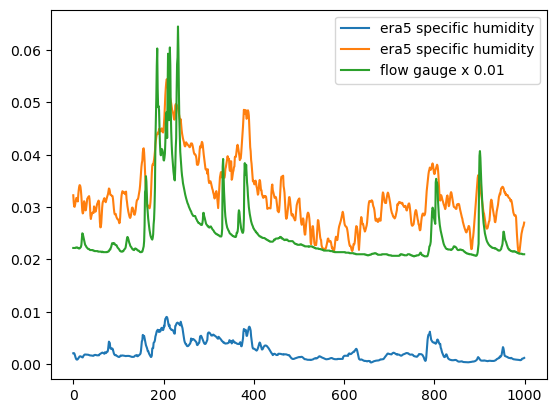

In [14]:
df_merged = pd.merge(df_all, df_era5, on='utc_timestamp')
fig, ax = plt.subplots(1)
ax.plot(df_merged['q-700'], label='era5 specific humidity')
ax.plot(df_merged['tcwv'] * 0.001, label='era5 specific humidity')
ax.plot(df_merged['measurement'] * 0.01, label='flow gauge x 0.01')
ax.legend()